<a href="https://colab.research.google.com/github/soleildeminuit/AI-Samhallsplanering-Course/blob/main/notebooks/Link%C3%B6ping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fetching location names...
   locationId                                               name
0         343  2005880AP112_City_of_Linköping_Trädgardsföreni...
1         180         2005880AP180_City_of_Linköping_Resecentrum
2         182         2005880AP182_City_of_Linköping_Resecentrum
3         426           2005880AP184_CoL_NykvarnsparkenNorthside
4         427                 2005880AP186_CoL_NykvarnsparkenMid
5         428              2005880AP187_CoL_NykvarnsparkenBridge
6         277  2005880AP41_City_of_Linköping_Trädgardsförenin...
7         278  2005880AP42_City_of_Linköping_Trädgardsförenin...
8         279  2005880AP44_City_of_Linköping_Trädgardsförenin...
9         284  2005880AP60_City_of_Linköping_Trädgardsförenin...
Fetching flow data from 277 to 278...


<Figure size 1200x600 with 0 Axes>

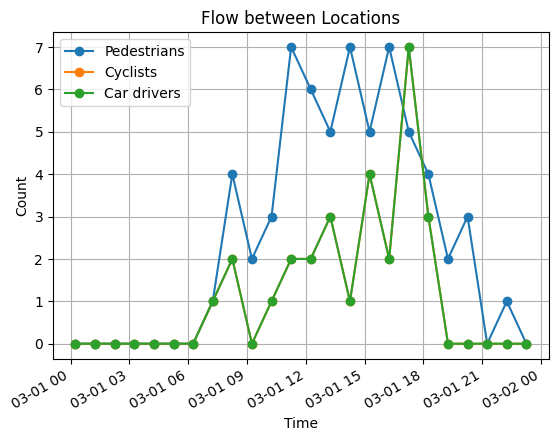

Fetching location data for 277...


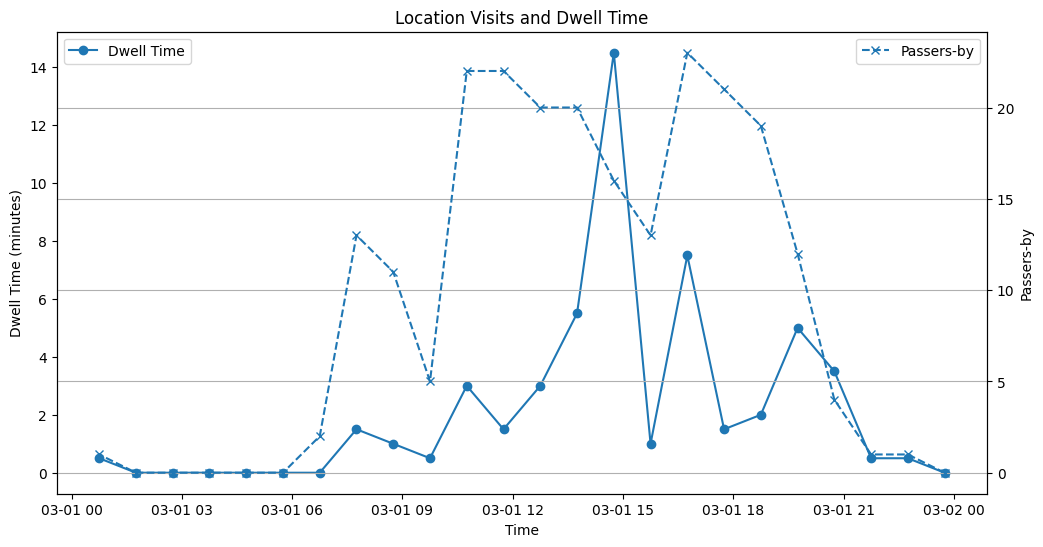

In [ ]:
# Linköping Mobility Patterns Visualization Script
# Designed to run in Google Colab

# If necessary, uncomment the following line to install dependencies:
# !pip install requests pandas matplotlib

import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Base URL for the Rörelsedata API
BASE_URL = "https://rorelsemonster.linkoping.se/api/v1"


def get_location_names():
    """
    Fetches all available location names and their IDs.
    Returns:
        pd.DataFrame: Columns [locationId, name]
    """
    url = f"{BASE_URL}/LocationNames"
    resp = requests.get(url)
    resp.raise_for_status()
    data = resp.json()
    return pd.DataFrame(data)


def get_flow_data(from_id: int, to_id: int, start: str, end: str, aggregation: str = "Week") -> pd.DataFrame:
    """
    Fetches flow data between two locations over a time range.
    Args:
        from_id (int): Source location ID
        to_id (int): Destination location ID
        start (str): ISO datetime string, e.g. "2021-03-01T00:00:00"
        end (str): ISO datetime string, e.g. "2021-03-02T00:00:00"
        aggregation (str): One of [HalfAnHour, Hour, Day, Week]
    Returns:
        pd.DataFrame indexed by registeredTime
    """
    params = {
        "From_Location_Id": from_id,
        "To_Location_Id": to_id,
        "From_DateTime": start,
        "To_DateTime": end,
        "aggregation": aggregation
    }
    resp = requests.get(f"{BASE_URL}/FlowData", params=params)
    resp.raise_for_status()
    df = pd.DataFrame(resp.json())
    df['registeredTime'] = pd.to_datetime(df['registeredTime'])
    return df.set_index('registeredTime')


def get_location_data(location_id: int, start: str, end: str, aggregation: str = "Week") -> pd.DataFrame:
    """
    Fetches visit and dwell data for a single location.
    Args:
        location_id (int): Location ID
        start (str): ISO datetime string
        end (str): ISO datetime string
        aggregation (str): One of [HalfAnHour, Hour, Day, Week]
    Returns:
        pd.DataFrame indexed by registeredTime
    """
    params = {
        "Location_Id": location_id,
        "From_DateTime": start,
        "To_DateTime": end,
        "aggregation": aggregation
    }
    resp = requests.get(f"{BASE_URL}/LocationData", params=params)
    resp.raise_for_status()
    df = pd.DataFrame(resp.json())
    df['registeredTime'] = pd.to_datetime(df['registeredTime'])
    return df.set_index('registeredTime')


def plot_flow(df: pd.DataFrame):
    """
    Time-series plot of flows by transport mode.
    """
    plt.figure(figsize=(12, 6))
    df[['flowPedestrians', 'flowCyclists', 'flowCarDrivers']].plot(marker='o')
    plt.title("Flow between Locations")
    plt.xlabel("Time")
    plt.ylabel("Count")
    plt.legend(["Pedestrians", "Cyclists", "Car drivers"])
    plt.grid(True)
    plt.show()


def plot_location(df: pd.DataFrame):
    """
    Combined plot of dwell time and passers-by counts for a location.
    """
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.plot(df.index, df['dwellTime'], marker='o', label='Dwell Time')
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Dwell Time (minutes)")
    ax1.legend(loc='upper left')

    ax2 = ax1.twinx()
    ax2.plot(df.index, df['passersBy'], marker='x', linestyle='--', label='Passers-by')
    ax2.set_ylabel("Passers-by")
    ax2.legend(loc='upper right')

    plt.title("Location Visits and Dwell Time")
    plt.grid(True)
    plt.show()


if __name__ == "__main__":
    # Example usage parameters
    from_id = 277
    to_id = 278
    location_id = 277
    start = "2021-03-01T00:00:00"
    end = "2021-03-02T00:00:00"
    aggregation = "Hour"

    print("Fetching location names...")
    locs = get_location_names()
    print(locs[['locationId', 'name']])

    print(f"Fetching flow data from {from_id} to {to_id}...")
    flow_df = get_flow_data(from_id, to_id, start, end, aggregation)
    plot_flow(flow_df)

    print(f"Fetching location data for {location_id}...")
    loc_df = get_location_data(location_id, start, end, aggregation)
    plot_location(loc_df)


In [ ]:
import plotly.graph_objects as go

fig = go.Figure(go.Bar(y=[2, 3, 1]))
fig.show()



In [20]:
import requests
import pandas as pd
import plotly.graph_objects as go

# === 1. Konfiguration ===
URL = "https://rorelsemonster.linkoping.se/api/v1/FlowData?fromLocationId=180&toLocationId=277&fromDateTime=2024-01-01T00:00:00&toDateTime=2024-05-31T00:00:00&aggregation=Week"
TRANS_MAP = {
    "flowPedestrians": "🚶 Fotgängare",
    "flowCyclists": "🚴 Cyklister",
    "flowCarDrivers": "🚗 Bilförare"
}

# === 2. Läs in data ===
response = requests.get(URL)
response.raise_for_status()
raw_data = response.json()

# === 3. Bearbeta till DataFrame ===
rows = []
for entry in raw_data:
    week = pd.to_datetime(entry["registeredTime"]).to_period("W").start_time.strftime("%Y-%m-%d")
    for key, label in TRANS_MAP.items():
        rows.append({
            "week": week,
            "transport": label,
            "count": entry[key]
        })
print(f"{label} – {e['registeredTime'][:10]} – {e['flowPedestrians']}")
df = pd.DataFrame(rows)

# === 4. Skapa nodlista (veckor + transportslag) ===
weeks = sorted(df["week"].unique().tolist())
transports = list(TRANS_MAP.values())
labels = weeks + transports
label_to_index = {label: i for i, label in enumerate(labels)}

# === 5. Skapa länkar för Sankey ===
sources = [label_to_index[row["week"]] for _, row in df.iterrows()]
targets = [label_to_index[row["transport"]] for _, row in df.iterrows()]
values = df["count"].tolist()
hover_text = [
    f"{row['week']} → {row['transport']}: {row['count']:,} flöden"
    for _, row in df.iterrows()
]

# === 6. Sankey-visualisering ===
fig = go.Figure(data=[go.Sankey(
    arrangement="snap",
    node=dict(
        pad=15,
        thickness=18,
        line=dict(color="gray", width=0.4),
        label=labels,
        color=["#aec7e8"] * len(weeks) + ["#1f77b4", "#ff7f0e", "#2ca02c"]  # färger för transportslag
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        hovertemplate=hover_text
    )
)])

# === 7. Layout ===
fig.update_layout(
    title_text="🌍 Rörelseflöde per vecka och transportslag – Resecentrum ➝ Trädgårdsföreningen",
    font=dict(size=12),
    height=700,
    margin=dict(l=20, r=20, t=50, b=20)
)
fig.show()


🚗 Bilförare – 2021-01-01 – 35288


✅ Hämtade 371 datapunkter för Trädgårdsföreningen

📊 Tillgängliga kolumner:
['vecka', 'dwellTime', 'loyaltyDistribution1stVisit', 'loyaltyDistributionReturningVisit', 'passersBy', 'weatherRainfall', 'weatherTemperature']


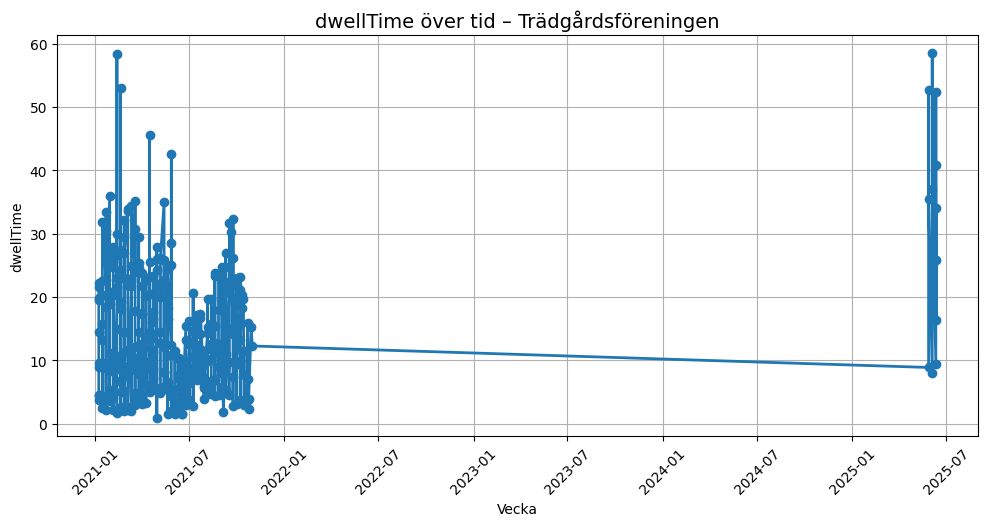

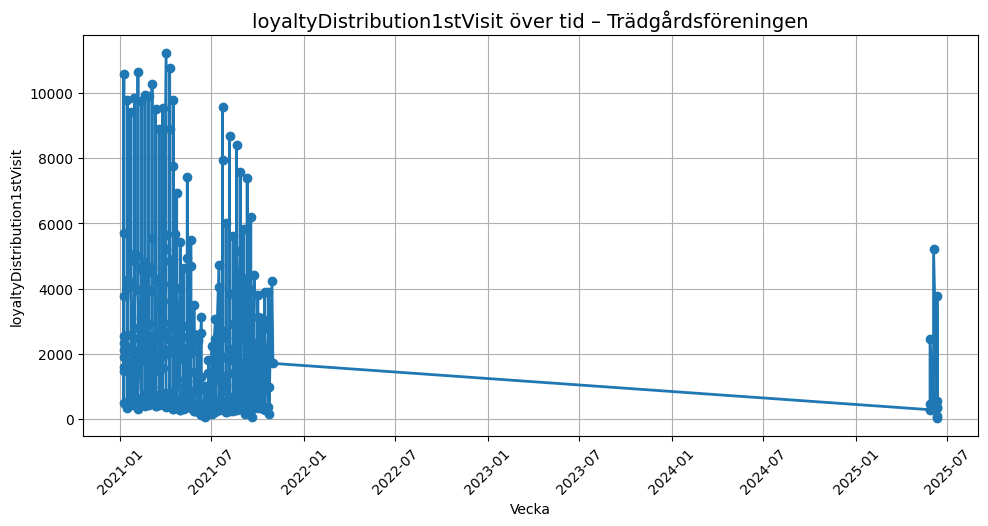

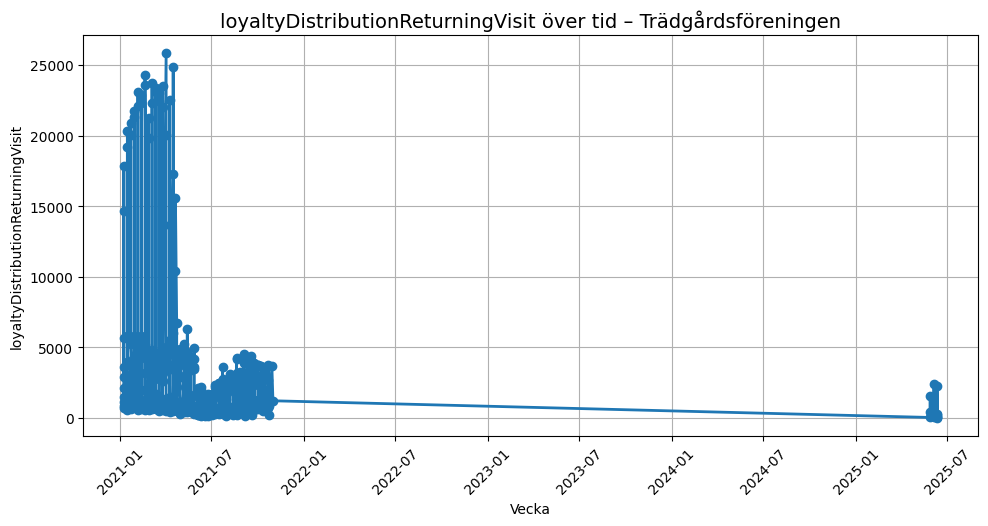

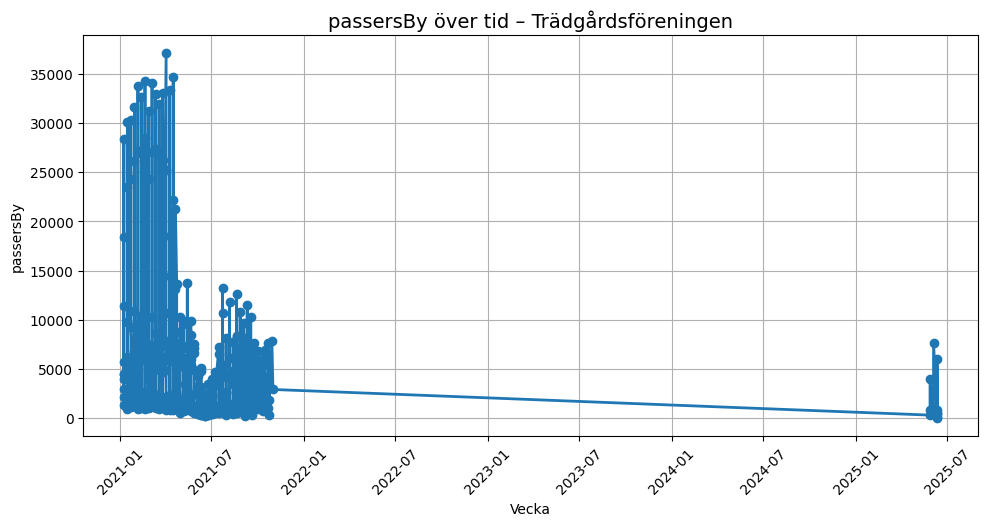

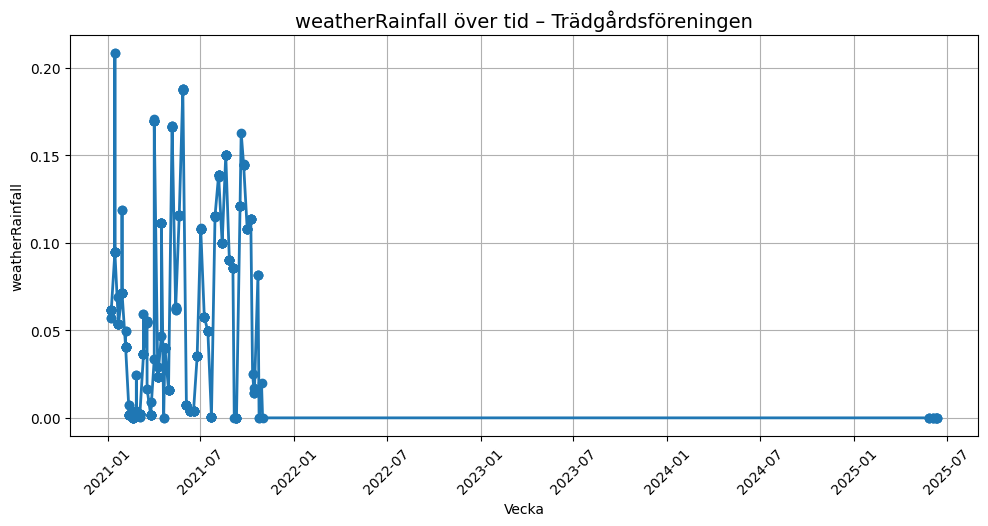

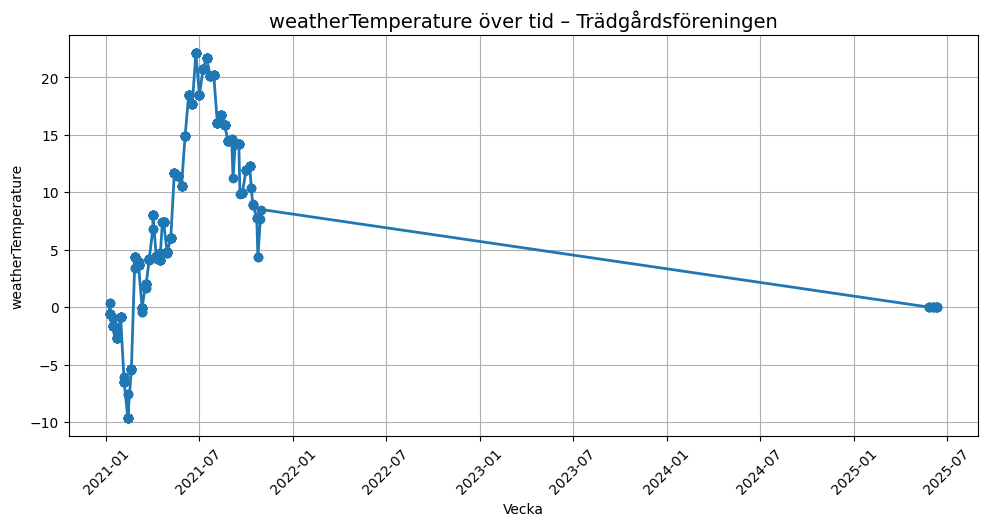

In [27]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 1. Inställningar
# ---------------------------------------------------------

LOCATION_ID = 343  # Trädgårdsföreningen
PLATS_NAMN = "Trädgårdsföreningen"
FROM_DATE = "2025-03-01T00:00:00"
TO_DATE   = "2025-06-01T00:00:00"
AGGREGATION = "Week"

# Skapa API-url baserat på inställningarna
API_URL = (
    f"https://rorelsemonster.linkoping.se/api/v1/LocationData"
    f"?locationId={LOCATION_ID}"
    f"&fromDateTime={FROM_DATE}"
    f"&toDateTime={TO_DATE}"
    f"&aggregation={AGGREGATION}"
)

# ---------------------------------------------------------
# 2. Hämta data från API
# ---------------------------------------------------------

try:
    response = requests.get(API_URL)
    response.raise_for_status()
    data = response.json()
    print(f"✅ Hämtade {len(data)} datapunkter för {PLATS_NAMN}")
except Exception as e:
    print(f"❌ Fel vid API-anrop: {e}")
    data = []

if not data:
    print("⚠️ Inga data att visualisera. Avslutar.")
    exit()

# ---------------------------------------------------------
# 3. Konvertera till DataFrame
# ---------------------------------------------------------

df = pd.DataFrame(data)
df["vecka"] = pd.to_datetime(df["registeredTime"])

# Sortera på tid
df = df.sort_values("vecka")

# Ta bort onödig kolumn
df = df.drop(columns=["registeredTime", "locationId"])

# Flytta "vecka" först
cols = ["vecka"] + [c for c in df.columns if c != "vecka"]
df = df[cols]

print("\n📊 Tillgängliga kolumner:")
print(df.columns.tolist())

# ---------------------------------------------------------
# 4. Skapa diagram för varje variabel
# ---------------------------------------------------------

plt.style.use("default")
for kolumn in df.columns:
    if kolumn == "vecka":
        continue

    plt.figure(figsize=(10, 5))
    plt.plot(df["vecka"], df[kolumn], marker="o", linewidth=2)

    plt.title(f"{kolumn} över tid – {PLATS_NAMN}", fontsize=14)
    plt.xlabel("Vecka")
    plt.ylabel(kolumn)
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()


✅ Hämtade 371 datapunkter för Trädgårdsföreningen


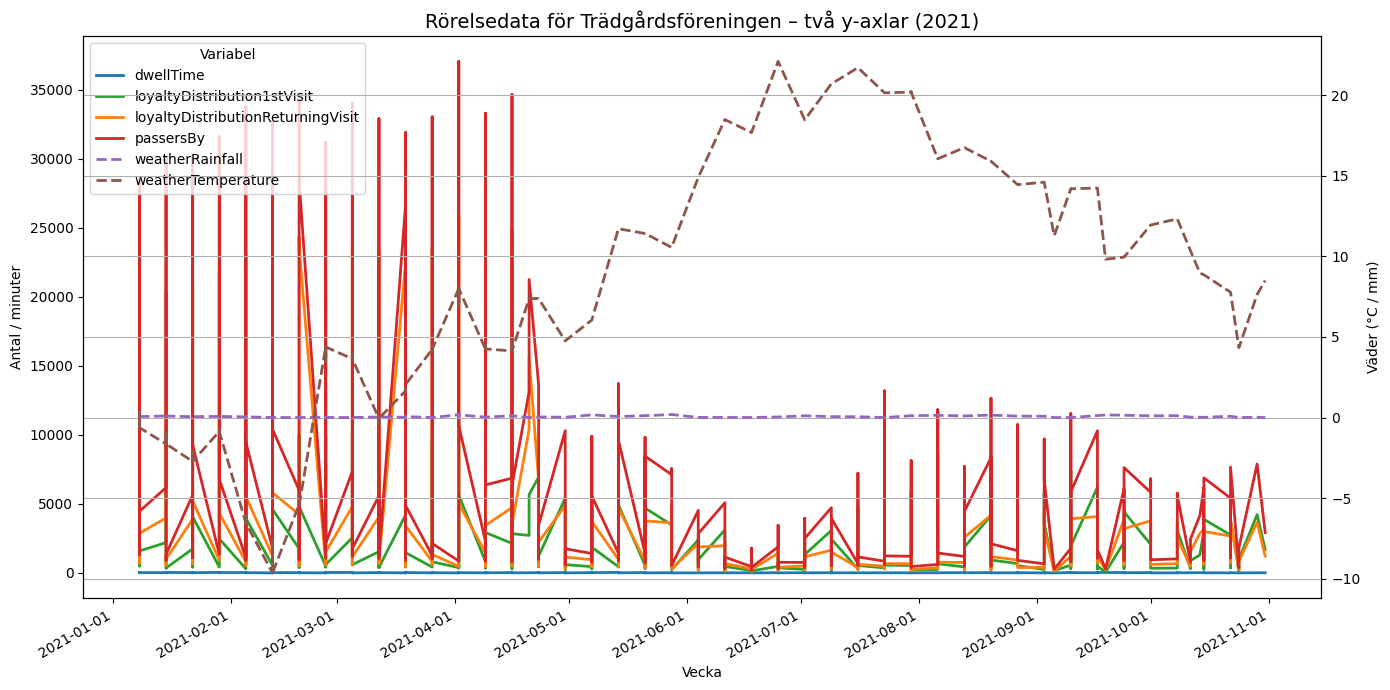

In [31]:
# ---------------------------------------------------------
# 0. Auto-installera bibliotek om de saknas
# ---------------------------------------------------------
# https://chatgpt.com/share/e/6849a549-5f68-800d-8b60-2ac4c766ccfe
import importlib.util
import subprocess
import sys

def install_if_missing(package):
    if importlib.util.find_spec(package) is None:
        print(f"📦 Installerar {package} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

for lib in ["requests", "pandas", "matplotlib"]:
    install_if_missing(lib)

# ---------------------------------------------------------
# 1. Importera bibliotek
# ---------------------------------------------------------
import requests
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# ---------------------------------------------------------
# 2. API-inställningar
# ---------------------------------------------------------
LOCATION_ID = 343
PLATS_NAMN = "Trädgårdsföreningen"
FROM_DATE = "2021-01-01T00:00:00"
TO_DATE   = "2021-12-31T23:59:59"
AGGREGATION = "Week"

API_URL = (
    f"https://rorelsemonster.linkoping.se/api/v1/LocationData"
    f"?locationId={LOCATION_ID}&fromDateTime={FROM_DATE}"
    f"&toDateTime={TO_DATE}&aggregation={AGGREGATION}"
)

# ---------------------------------------------------------
# 3. Hämta och filtrera data
# ---------------------------------------------------------
try:
    response = requests.get(API_URL)
    response.raise_for_status()
    data = response.json()
    print(f"✅ Hämtade {len(data)} datapunkter för {PLATS_NAMN}")
except Exception as e:
    print(f"❌ Fel vid API-anrop: {e}")
    sys.exit(1)

if not data:
    print("⚠️ Inga data att visualisera. Avslutar.")
    sys.exit(0)

df = pd.DataFrame(data)
df["vecka"] = pd.to_datetime(df["registeredTime"])
df = df[(df["vecka"].dt.year == 2021)].sort_values("vecka")

# ---------------------------------------------------------
# 4. Skapa tvåaxlat diagram
# ---------------------------------------------------------
fig, ax1 = plt.subplots(figsize=(14, 7))
ax2 = ax1.twinx()

# Färger och gruppering
färg1 = {
    "dwellTime": "tab:blue",
    "loyaltyDistribution1stVisit": "tab:green",
    "loyaltyDistributionReturningVisit": "tab:orange",
    "passersBy": "tab:red"
}
färg2 = {
    "weatherRainfall": "tab:purple",
    "weatherTemperature": "tab:brown"
}

# Plotta axel 1 (vänster)
for kolumn, färg in färg1.items():
    ax1.plot(df["vecka"], df[kolumn], label=kolumn, color=färg, linewidth=2)

# Plotta axel 2 (höger)
for kolumn, färg in färg2.items():
    ax2.plot(df["vecka"], df[kolumn], label=kolumn, color=färg, linestyle='--', linewidth=2)

# Format och etiketter
ax1.set_title(f"Rörelsedata för {PLATS_NAMN} – två y-axlar (2021)", fontsize=14)
ax1.set_xlabel("Vecka")
ax1.set_ylabel("Antal / minuter")
ax2.set_ylabel("Väder (°C / mm)")
ax1.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
fig.autofmt_xdate()

# Sammanfoga legender
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left", title="Variabel")

plt.grid(True)
plt.tight_layout()
plt.show()


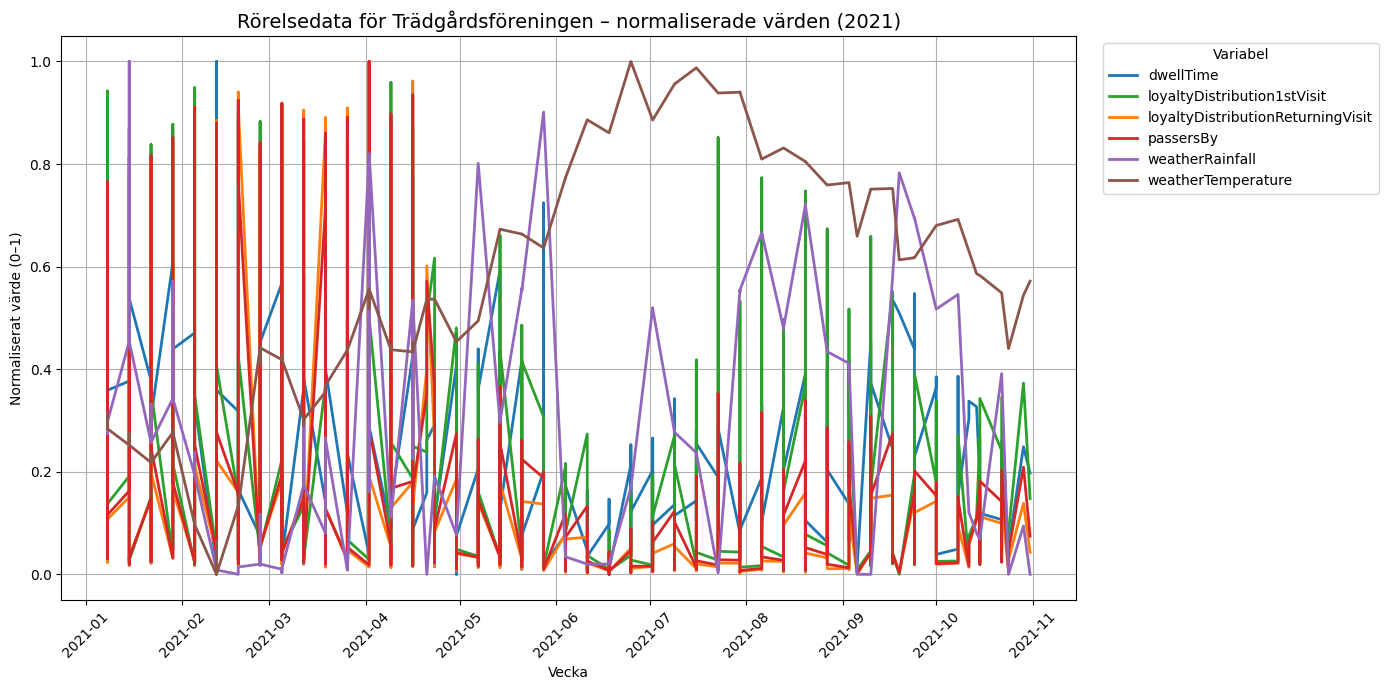

In [32]:
# ---------------------------------------------------------
# Samma del 0–3 som ovan
# ---------------------------------------------------------
# Hoppa till steg 4:

# ---------------------------------------------------------
# 4. Normalisera data
# ---------------------------------------------------------
# https://chatgpt.com/share/e/6849a549-5f68-800d-8b60-2ac4c766ccfe
värdekolumner = [
    "dwellTime", "loyaltyDistribution1stVisit",
    "loyaltyDistributionReturningVisit", "passersBy",
    "weatherRainfall", "weatherTemperature"
]
df = df[["vecka"] + värdekolumner]

# Normalisering: min-max per kolumn
df_norm = df.copy()
for kolumn in värdekolumner:
    min_val = df[kolumn].min()
    max_val = df[kolumn].max()
    if max_val > min_val:
        df_norm[kolumn] = (df[kolumn] - min_val) / (max_val - min_val)
    else:
        df_norm[kolumn] = 0  # hanterar konstant kolumn

# ---------------------------------------------------------
# 5. Visualisering av normaliserade värden
# ---------------------------------------------------------
plt.figure(figsize=(14, 7))
färger = [
    "tab:blue", "tab:green", "tab:orange",
    "tab:red", "tab:purple", "tab:brown"
]

for kolumn, färg in zip(värdekolumner, färger):
    plt.plot(df["vecka"], df_norm[kolumn], label=kolumn, color=färg, linewidth=2)

plt.title(f"Rörelsedata för {PLATS_NAMN} – normaliserade värden (2021)", fontsize=14)
plt.xlabel("Vecka")
plt.ylabel("Normaliserat värde (0–1)")
plt.grid(True)
plt.xticks(rotation=45)
plt.legend(title="Variabel", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


✅ 371 datapunkter hämtade från API.


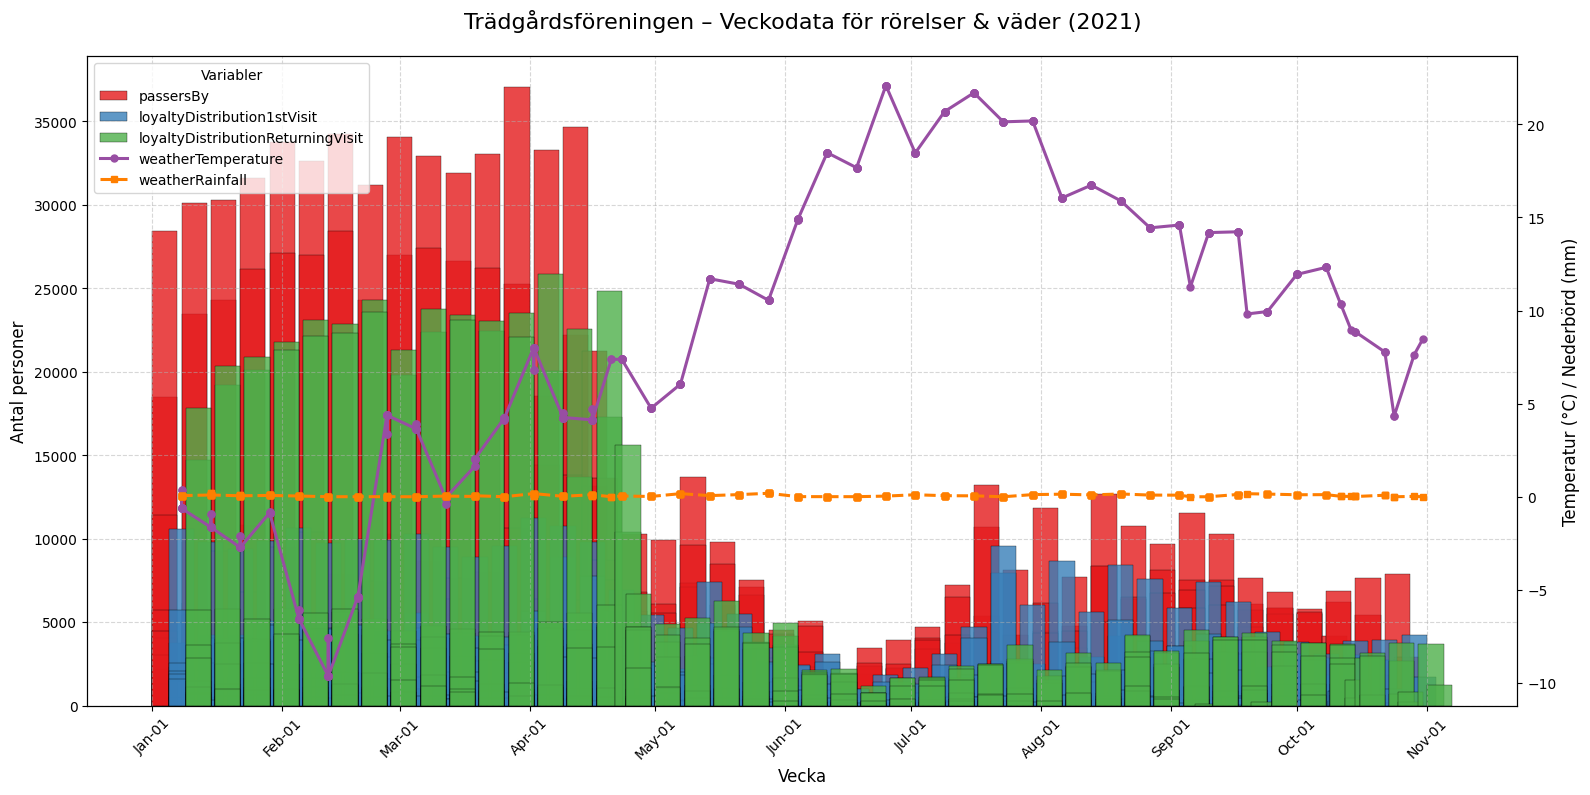

In [34]:
# ---------------------------------------------------------
# 0. Auto-installera bibliotek om de saknas
# ---------------------------------------------------------
# https://chatgpt.com/share/e/6849a549-5f68-800d-8b60-2ac4c766ccfe
import importlib.util
import subprocess
import sys

def install_if_missing(package):
    if importlib.util.find_spec(package) is None:
        print(f"📦 Installerar {package} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

for lib in ["requests", "pandas", "matplotlib"]:
    install_if_missing(lib)

# ---------------------------------------------------------
# 1. Importera bibliotek
# ---------------------------------------------------------
import requests
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# ---------------------------------------------------------
# 2. API-inställningar
# ---------------------------------------------------------
LOCATION_ID = 343
PLATS_NAMN = "Trädgårdsföreningen"
FROM_DATE = "2021-01-01T00:00:00"
TO_DATE   = "2021-12-31T23:59:59"
AGGREGATION = "Week"

API_URL = (
    f"https://rorelsemonster.linkoping.se/api/v1/LocationData"
    f"?locationId={LOCATION_ID}"
    f"&fromDateTime={FROM_DATE}&toDateTime={TO_DATE}"
    f"&aggregation={AGGREGATION}"
)

# ---------------------------------------------------------
# 3. Hämta och förbered data
# ---------------------------------------------------------
try:
    res = requests.get(API_URL)
    res.raise_for_status()
    data = res.json()
    print(f"✅ {len(data)} datapunkter hämtade från API.")
except Exception as e:
    print(f"❌ Fel vid hämtning: {e}")
    sys.exit(1)

if not data:
    print("⚠️ Ingen data att visualisera.")
    sys.exit(0)

df = pd.DataFrame(data)
df["vecka"] = pd.to_datetime(df["registeredTime"])
df = df[df["vecka"].dt.year == 2021].sort_values("vecka")

# ---------------------------------------------------------
# 4. Visualisering med förbättrad estetik
# ---------------------------------------------------------
fig, ax1 = plt.subplots(figsize=(16, 8))
ax2 = ax1.twinx()

# Datakategorier
rörelse = ["passersBy", "loyaltyDistribution1stVisit", "loyaltyDistributionReturningVisit"]
väder = ["weatherTemperature", "weatherRainfall"]

# Färgtema
färger = {
    "passersBy": "#e41a1c",
    "loyaltyDistribution1stVisit": "#377eb8",
    "loyaltyDistributionReturningVisit": "#4daf4a",
    "weatherTemperature": "#984ea3",
    "weatherRainfall": "#ff7f00"
}

# Ritlogik
offsets = [-4, 0, 4]  # för staplarna
for i, kol in enumerate(rörelse):
    ax1.bar(
        df["vecka"] + pd.to_timedelta(offsets[i], unit="D"),
        df[kol],
        width=6,
        label=kol,
        color=färger[kol],
        alpha=0.8,
        edgecolor='black',
        linewidth=0.3
    )

for kol in väder:
    ax2.plot(
        df["vecka"],
        df[kol],
        label=kol,
        color=färger[kol],
        linewidth=2.2,
        linestyle="--" if "Rain" in kol else "-",
        marker='o' if "Temperature" in kol else 's',
        markersize=5
    )

# Etiketter, format och rutnät
ax1.set_title(f"{PLATS_NAMN} – Veckodata för rörelser & väder (2021)", fontsize=16, pad=20)
ax1.set_xlabel("Vecka", fontsize=12)
ax1.set_ylabel("Antal personer", fontsize=12)
ax2.set_ylabel("Temperatur (°C) / Nederbörd (mm)", fontsize=12)
ax1.xaxis.set_major_formatter(DateFormatter("%b-%d"))
ax1.tick_params(axis="x", rotation=45)
ax1.grid(True, which='major', linestyle='--', alpha=0.5)

# Sammanfogad legend
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, title="Variabler", loc="upper left", fontsize=10)

# Layout
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()
